In [1]:
import numpy as np
import scipy as sp
import scipy.linalg as la 
import scipy.sparse.linalg as spla
import time 
import matplotlib.pyplot as plt
import cmath

%matplotlib inline

### Problem 1.
Write a function that accepts the adjacency matrix of a graph as an argument and returns the Laplacian matrix. Test your function on the graphs in Figures 5.1 and 5.2.

Hint: You can compute the diagonal of the degree matrix in one line by summing over an axis (see Lab 2 and NumPy Visual Guide).

In [2]:
def laplacian(A):
    """
    A - adjacency matrix
    """
    return np.diag(np.sum(A, axis=0)) - A

In [3]:
#test
A1 = np.array([[0,1,0,0,1,1],
               [1,0,1,0,1,0],
               [0,1,0,1,0,0],
               [0,0,1,0,1,1],
               [1,1,0,1,0,0],
               [1,0,0,1,0,0]])
A2 = np.array([[0,3,0,0,0,0],
               [3,0,0,0,0,0],
               [0,0,0,1,0,0],
               [0,0,1,0,2,.5],
               [0,0,0,2,0,1],
               [0,0,0,.5,1,0]])

In [4]:
laplacian(A1)

array([[ 3, -1,  0,  0, -1, -1],
       [-1,  3, -1,  0, -1,  0],
       [ 0, -1,  2, -1,  0,  0],
       [ 0,  0, -1,  3, -1, -1],
       [-1, -1,  0, -1,  3,  0],
       [-1,  0,  0, -1,  0,  2]])

In [5]:
laplacian(A2)

array([[ 3. , -3. ,  0. ,  0. ,  0. ,  0. ],
       [-3. ,  3. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. , -1. ,  0. ,  0. ],
       [ 0. ,  0. , -1. ,  3.5, -2. , -0.5],
       [ 0. ,  0. ,  0. , -2. ,  3. , -1. ],
       [ 0. ,  0. ,  0. , -0.5, -1. ,  1.5]])

### Problem 2 
Compute the number of connected components in a graph. Write a function that accepts the adjacency matrix of a graph and returns two arguments: the number of connected components, and the algebraic connectivity of the graph (second smallest eigenvalue of the Laplacian).


Use the `scipy.linalg` package to compute the eigenvalues. Note that this package will return complex eigenvalues (with negligible imaginary parts). Keep only the real parts. Your function should also accept a tolerance value, such that all eigenvalues less than this value are assumed to be zero. This should default to `tol=1e-8`.

In [6]:
def connectedness(A, tol = 1e-8):
    """
    PARAMETERS:
    A:      adjacency matrix.
    tol:    tolerance value for considering zero values.
    
    RETURNS:
    num_con_graphs:  number of connected graphs
    adj_con: algebraic connectivity of the the graph(second smallest eig of L)
    """
    L = laplacian(A)
    eigvals,_ = la.eig(L)
    real_eigs = np.array([i if i>tol else 0 for i in np.real(eigvals)])
    num_con_graphs = np.sum(real_eigs==0)
    alg_con = sorted(real_eigs[real_eigs!=0])[0]
    
    return num_con_graphs, alg_con

In [7]:
connectedness(A2)

(2, 1.0000000000000002)

### Problem 3.

Write the function adjacency described in this section. Accept an image a filename and constants radius, sigma_I, and sigma_d. Return the corresponding sparse adjacency matrix W and the diagonal of the degree ma- trix D. Use (5.1) to compute the weights in the adjacency matrix. For speed, try to compute an entire row of W at once, instead of filling in W entry by entry.

In [8]:
filename = "../Data/Volume1/dream.png"

In [9]:
def getImage(filename):
    image_mat = plt.imread(filename)
    image_mat_2d = np.mean(image_mat, axis=2)
    return image_mat, image_mat_2d

def getNeighbors(index, r, orig_shape):
    rad = int(r)+1
    index_ = (index//orig_shape[1], index%orig_shape[0]) #row and col num
    x = np.arange(max(0, index_[0]-rad), min(orig_shape[0], index_[0]+rad+1))
    y = np.arange(max(0, index_[1]-rad), min(orig_shape[1], index_[1]+rad+1))
    x,y = [i.T for i in np.meshgrid(x,y)]

    
    distance = np.sqrt((index_[0] - x)**2 + (index_[1] - y)**2).flatten()
    indices = np.where(distance<=r)[0]
    return (x*orig_shape[0]+y).flatten()[indices], distance[indices]

In [10]:
def adjacency(filename, radius=6, sigma_I=0.10, sigma_d=20):
    image_mat, image_mat_2d = getImage(filename)
    image_mat_flat = image_mat_2d.flatten()
    M,N = image_mat_2d.shape
    
    adjacency_mat = sp.sparse.lil_matrix((M*N, M*N))
    diag_deg = np.zeros(M*N)
    
    for i in range(M*N):
        indices, distances = getNeighbors(i, radius, (M,N))
        weights = np.exp(-(np.abs(image_mat_flat[i] - image_mat_flat[indices])/sigma_I**2) - \
                          (distances/sigma_d**2))
        adjacency_mat[i, indices] = weights
        diag_deg[i] = np.sum(weights)
    
    adjacency_mat = sp.sparse.csc_matrix(adjacency_mat)
    return adjacency_mat, diag_deg

In [11]:
W, D = adjacency(filename)

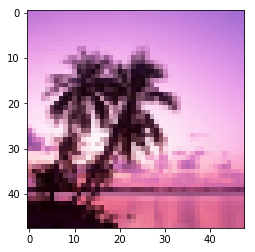

In [12]:
image_mat, image_mat_2d = getImage(filename)
plt.imshow(image_mat)

### Problem 4
Write the function segment to segment an image. The function should accept an image filename and return both of the segments. You should call the code you wrote in Problem 3. Use sparse matrices where possible.
Test on the image dream.png. Your segments should look like the segments in Figure 5.5 (the original image is on the left).
Hints:
1. After defining $D^{-\frac{1}{2}}$, convert $D$ and  $D^{-\frac{1}{2}}$ into sparse matrices using `scipy.sparse.spdiags`.
2. Since we are now dealing with sparse instead of dense matrices,you shouldn’t use your solution to Problem 1 to calculate the Laplacian.
3. Multiply sparse matrices with A.dot(B).
4. Use scipy.sparse.eigsh to calculate the eigenvector. This is a sparse eigenvalue solver optimized for symmetric matrices. Set the keyword which = "SM" to return the smallest eigenvalues.
5. The provided function displayPosNeg can be used to plot your images.

In [13]:
def segment(img_fname, radius=6, sigma_I=0.10, sigma_d=20):
    W, D = adjacency(img_fname, radius, sigma_I, sigma_d)
    
    D_05 = D**(-1./2)
    D = sp.sparse.spdiags(D, diags=0, m=len(D), n=len(D))
    D_05 = sp.sparse.spdiags(D_05, diags=0, m=len(D_05), n=len(D_05))
    
    L = D - W #laplacian matrix
    M = (D_05.dot(L)).dot(D_05) 
    eigvals, eigvecs = sp.sparse.linalg.eigsh(M, which="SM")
    
    #segments
    image_mat, image_mat_2d = getImage(img_fname)
    bool_ = (eigvecs[:,1]>0).reshape(image_mat_2d.shape)
    
    return image_mat_2d*bool_, image_mat_2d*(~bool_)

In [14]:
segment1, segment2 = segment(filename, radius=6, sigma_I=0.10, sigma_d=20)

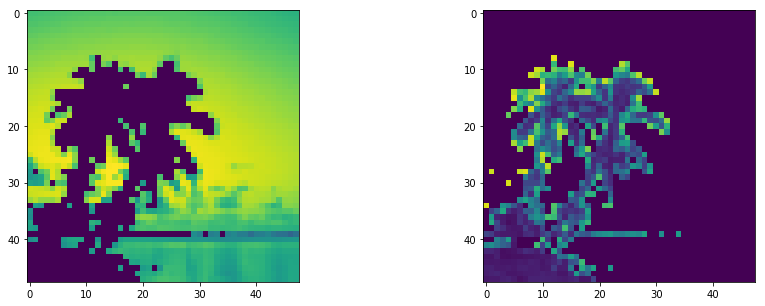

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(segment1)
ax[1].imshow(segment2)

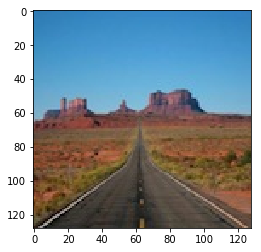

In [16]:
fil2 = "../Data/Volume1/RegMon.png"
plt.imshow(plt.imread(fil2))

In [17]:
seg1, seg2 = segment(fil2, 6, sigma_I=0.10, sigma_d=40)

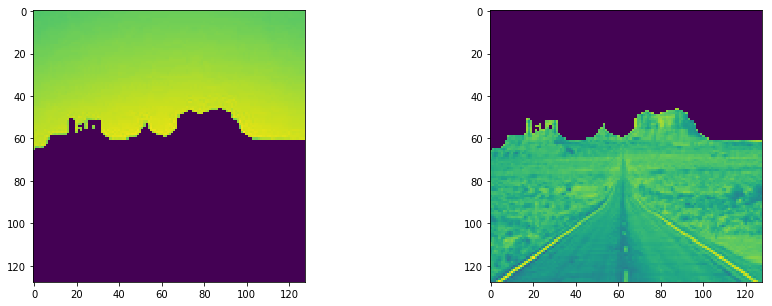

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(seg1)
ax[1].imshow(seg2)